In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
import gsw
from datetime import datetime

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Functions

In [2]:
def get_vars(dirname, fname, meshmaskname, time_ind, dep_ind_slice):
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U') 
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        vosaline0 = dsT.variables['vosaline'][time_ind, :dep_ind_slice+1, y, x]
        votemper0 = dsT.variables['votemper'][time_ind, :dep_ind_slice+1, y, x]
        sossheig0 = dsT.variables['sossheig'][time_ind, y, x]
        vozocrtx0 = dsU.variables['vozocrtx'][time_ind, dep_ind_slice, y, x]
        vomecrty0 = dsV.variables['vomecrty'][time_ind, dep_ind_slice, y, x]
        vovecrtz0 = dsW.variables['vovecrtz'][time_ind, dep_ind_slice, y, x]
        deptht = dsT.variables['deptht'][:]
        sozotaux = dsU.variables['sozotaux'][:, 0, 0]        
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        tmask_all = dsM.variables['tmask'][0, :dep_ind_slice+1, y, x]
        tmask_ss = dsM.variables['tmask'][0, 0, y, x]
        tmask = dsM.variables['tmask'][0, dep_ind_slice, y, x]
        umask = dsM.variables['umask'][0, dep_ind_slice, y, x]
        vmask = dsM.variables['vmask'][0, dep_ind_slice, y, x]
        e3t = dsM.variables['e3t_0'][0, :dep_ind_slice+1, 0, 0]
        e1u = dsM.variables['e1u'][0, y, x]
        e2u = dsM.variables['e2u'][0, y, x]
        
    vosaline = np.ma.array(vosaline0, mask=1 - tmask_all)
    votemper = np.ma.array(votemper0, mask=1 - tmask_all)
    sossheig = np.ma.array(sossheig0, mask=1 - tmask_ss)
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    return vosaline, votemper, sossheig, vozocrtx, vomecrty, vovecrtz, deptht, sozotaux, tmask, umask, e3t, e1u, e2u

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

## Speeds

In [4]:
def execute_speeds(vozocrtx, vomecrty, arrow, umask):
    if arrow==1:
        mask_slice = umask[:-1, :-1]
    else:
        mask_slice = umask[::arrow, ::arrow]
    x_slice, y_slice, u_nstg, v_nstg, speeds = quicklook.get_speeds(vozocrtx, vomecrty, arrow)
    u_nstg_ma = np.ma.array(u_nstg, mask=1 - mask_slice)
    v_nstg_ma = np.ma.array(v_nstg, mask=1 - mask_slice)
    speeds_ma = np.ma.array(speeds, mask=1 - mask_slice)
    return x_slice, y_slice, u_nstg_ma, v_nstg_ma, speeds_ma, mask_slice

## Pressure

In [5]:
def calculate_pressure(vosaline, votemper, sossheig, e3t):
    g = 9.81

    rho = np.full([vosaline.shape[-3], vosaline.shape[-2], vosaline.shape[-1]], np.nan)
    p_stat0 = np.full_like(rho, np.nan)
    p_stat = np.full_like(rho, np.nan)
    p_surf = np.full([vosaline.shape[-2], vosaline.shape[-1]], np.nan)
    pressure = np.full_like(rho, np.nan)

    for k in range(vosaline.shape[-3]):
        gsw_vosaline = vosaline[k, :, :]
        gsw_votemper = votemper[k, :, :]
        rho[k, :, :] = gsw.rho(gsw_vosaline, gsw_votemper, 0)
        p_stat0[k, :, :] = rho[k, :, :] * e3t[k]

    for k in range(len(e3t)): 
        p_stat[k, :, :] = g * np.sum(p_stat0[:k, :, :], axis=0)

    p_surf[:, :] = rho[0, :, :] * g * sossheig[:, :]

    for k in range(vosaline.shape[-3]):
        pressure[k, :, :] = p_stat[k, :, :] + p_surf[:, :]

    pressure_db = pressure * 0.0001
        
    return rho, pressure_db

## Vorticity

In [6]:
def calculate_relative_vorticitity(time_ind, vomecrty, vozocrtx, e1v, e2u, umask):
    if len(vomecrty.shape) > 2:
        V = vomecrty[time_ind, :, :]
        U = vozocrtx[time_ind, :, :]
    else:
        V = vomecrty
        U = vozocrtx
    
    dV = np.diff(V, axis=-1)
    dx = e1v[..., :-1]
    dVdx = dV/dx
    
    dU = np.diff(U, axis=-2)
    dy = e2u[:-1, ...]
    dUdy = dU/dy

    zeta0 = dVdx[:-1, ...] - dUdy[..., :-1]
    zeta = np.ma.array(zeta0, mask = 1 - umask[:-1, :-1])
    
    return dV, dx, dU, dy, dVdx, dUdy, zeta

## Shelf Velocities

In [7]:
def get_shelf_velocities(dirname, fname, meshmaskname):
    x_start = 200
    x_end = 230
    y_start = 45
    y_end = 190
    dep_start = 2
    dep_end = 6
    flag = 'U'
    vozocrtx, umask, umask_all, depthu, e1u, e2u, sozotaux = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
    avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = quicklook.calculate_avg_vel(vozocrtx, dep_start, dep_end)
    avgU_absolute_smoothed = general_functions.smooth(avgU_absolute[:], 12)
    
    return avgU_absolute_smoothed 

## Values and Plots

In [8]:
def execute_functions(dirname, fname, meshmaskname, dep_ind_slice, time_ind, vosaline_ref_profile):

    vosaline, votemper, sossheig, vozocrtx, vomecrty, vovecrtz, deptht, sozotaux, tmask, umask, e3t, e1u, e2u = get_vars(dirname, fname, meshmaskname, time_ind, dep_ind_slice)
    print(vosaline.shape, votemper.shape, sossheig.shape, vozocrtx.shape, vomecrty.shape, vovecrtz.shape, deptht.shape, sozotaux.shape, tmask.shape, e3t.shape)

    x_slice, y_slice, u_nstg, v_nstg, speeds, mask_slice = execute_speeds(vozocrtx, vomecrty, 1, umask)

    rho, pressure_db = calculate_pressure(vosaline, votemper, sossheig, e3t)
    print(rho.shape, pressure_db.shape)

    dV, dx, dU, dy, dVdx, dUdy, zeta = calculate_relative_vorticitity(None, vomecrty, vozocrtx, e1u, e2u, umask)
    print(zeta.shape)

    avgU_abs_sm = get_shelf_velocities(dirname, fname, meshmaskname)

    depth_ind_daily = upwelling_functions.get_daily_depth_ind(vosaline[dep_ind_slice], vosaline_ref_profile)
    depth_m_daily, depth_upwelled = upwelling_functions.get_daily_depth_m(deptht, dep_ind_slice, depth_ind_daily, tmask)
    print(depth_ind_daily.shape, depth_upwelled.shape)
    
    return x_slice, y_slice, u_nstg, v_nstg, speeds, vovecrtz, pressure_db, zeta, vosaline, depth_upwelled, sozotaux, avgU_abs_sm, tmask, deptht

In [20]:
def make_frame():
    
    fig = plt.figure(figsize=(20, 21))
    ax1 = plt.subplot2grid((11, 12), (0, 0), colspan=4, rowspan=4)
    ax2 = plt.subplot2grid((11, 12), (0, 4), colspan=4, rowspan=4)
    ax3 = plt.subplot2grid((11, 12), (0, 8), colspan=4, rowspan=4)

    ax4 = plt.subplot2grid((11, 12), (4, 0), colspan=4, rowspan=4)
    ax5 = plt.subplot2grid((11, 12), (4, 4), colspan=4, rowspan=4)
    ax6 = plt.subplot2grid((11, 12), (4, 8), colspan=4, rowspan=4)

    axa = plt.subplot2grid((11, 12), (9, 0), colspan=12, rowspan=1)
    axb = plt.subplot2grid((11, 12), (10, 0), colspan=12, rowspan=1)
    
    colour_list = ["#c8274c","#f25546","#F06543","#e96e33","#f0b038","#FFE74C",
                   "#69b944","#72b286","#69b0bc","#619ee4","#4b5bbb"][::-1]
    
    cmap_mask = LinearSegmentedColormap.from_list('mycmap', ['silver', 'white'])
    cmap1 = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)
    cmap2 = cmo.cm.balance
    cmap3 = cmo.cm.deep
    cmap4 = cmo.cm.balance
    cmap5 = cmo.cm.matter
    cmap6 = cmo.cm.delta
    
    return fig, ax1, ax2, ax3, ax4, ax5, ax6, axa, axb, cmap_mask, cmap1, cmap2, cmap3, cmap4, cmap5, cmap6

In [26]:
def plot_story(x_slice, y_slice, u_nstg, v_nstg, speeds, 
               vovecrtz, pressure_db, zeta, vosaline, depth_upwelled, sozotaux, avgU_abs_sm, tmask, deptht, 
               dep_ind_slice, kind, case):

    fig, ax1, ax2, ax3, ax4, ax5, ax6, axa, axb, cmap_mask, cmap1, cmap2, cmap3, cmap4, cmap5, cmap6 = make_frame()

    vm_w = max([abs(np.nanmin(vovecrtz)), abs(np.nanmax(vovecrtz))])*0.2
    vm_r = max([abs(np.nanmin(zeta)), abs(np.nanmax(zeta))])*0.2
    vmin_s, vmax_s = np.nanmin(vosaline[dep_ind_slice]), np.nanmax(vosaline[dep_ind_slice])
    norm = mpl.colors.Normalize(vmin=vmin_v, vmax=vmax_v)

    # ------------------------------------------
    ax=ax1
    cmap=cmap1
    cmap.set_bad('silver')
    p1 = ax.pcolormesh(x_slice, y_slice, speeds, cmap=cmap)
    strm = ax.streamplot(x_slice, y_slice, u_nstg, v_nstg, color='k', linewidth=1, density=5, zorder=2)

    # ------------------------------------------
    ax=ax2
    cmap=cmap2
    cmap.set_bad('silver')
    p2 = ax.pcolormesh(vovecrtz, cmap=cmap, vmin=-1*vm_w, vmax=vm_w)

    # ------------------------------------------
    ax=ax3
    cmap=cmap3
    cmap.set_bad('silver')
    p3 = ax.pcolormesh(pressure_db[dep_ind_slice], cmap=cmap)

    # ------------------------------------------
    ax=ax4
    cmap=cmap4
    cmap.set_bad('silver')
    p4=ax.pcolormesh(zeta, cmap=cmap4, vmin=-1*vm_r, vmax=vm_r)

    # ------------------------------------------
    ax=ax5
    cmap=cmap5
    cmap.set_bad('silver')
    p5=ax.pcolormesh(vosaline[dep_ind_slice], cmap=cmap, vmin=vmin_s, vmax=vmax_s)

    # ------------------------------------------
    ax=ax6
    cmap=cmap6
    norm = upwelling_functions.MidpointNormalize(midpoint=0)
    cmap.set_bad('silver')
    p6=ax.pcolormesh(depth_upwelled, cmap=cmap, norm=norm)

    # ------------------------------------------
    ax=axa
    ax.plot(sozotaux, c='dimgray', lw=2)
    ax.axhline(0, linestyle='-', c='k', lw=1)
    ax.scatter(time_ind, sozotaux[time_ind], s=90, c='orangered')
    ax.set_title('Wind Stress', fontsize=23)
    ax.set_ylabel('[Nm$^{-2}$]', fontsize=20)
    ax.set_ylim([-2.0, 1.0])
    ax.set_xlim([0, 10*24])
    ax.xaxis.set_ticks(np.arange(0, 10*24, 24))
    ax.grid()

    # ------------------------------------------
    ax=axb
    ax.plot(avgU_abs_sm, c='dimgray', lw=2)
    ax.axhline(0, linestyle='-', c='k', lw=1)
    ax.scatter(time_ind, avgU_abs_sm[time_ind], s=90, c='orangered')
    ax.set_title('Shelf Currents Velocity', fontsize=23)
    ax.set_xlabel('Time [hours]', fontsize=15)
    ax.set_ylabel('[ms$^{-1}$]', fontsize=20)
    ax.set_ylim([-0.7, 0.3])
    ax.set_xlim([0, 10*24])
    ax.xaxis.set_ticks(np.arange(0, 10*24, 24))
    ax.grid()

    # ------------------------------------------
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    ps = [p1,p2,p3,p4,p5,p6]
    ttls = ['streamlines', 'w-velocity', 'pressure', 'vorticity', 'salinity', 'upwelling depth']
    cblabs = ['[ms$^{-1}$]', '[ms$^{-1}$]', '[dbar]', '[s$^{-1}$]', '[gkg$^{-1}$]', '[m]']
    for ax, p, ttl, cblab in zip(axes, ps, ttls, cblabs):
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([0, tmask.shape[-1]])
        ax.set_ylim([0, tmask.shape[-2]])
        cbar = fig.colorbar(p, ax=ax, fraction=0.05, orientation='horizontal', pad=0.02)
        cbar.ax.tick_params(labelsize=16)
        tick_locator = ticker.MaxNLocator(nbins=6)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.set_label(cblab, fontsize=20)
        ax.set_title(ttl, fontsize=23)

    # ------------------------------------------
    fig.tight_layout(w_pad=0.05, h_pad=0.05)
    fig.suptitle(kind + ' - ' + case +': depth [m] = '+str(int(deptht[dep_ind_slice]))+
                 ', time [hrs] = '+str(time_ind), fontsize=26)
    plt.subplots_adjust(top=0.96)
    
    return fig

# Constants

In [11]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

# ------------------------------------------------------------

dep_ind_slices = [9, 16]
time_inds = [12, 36, 120]

# Ideal

In [12]:
kind = 'ideal'
case = 'base' 
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

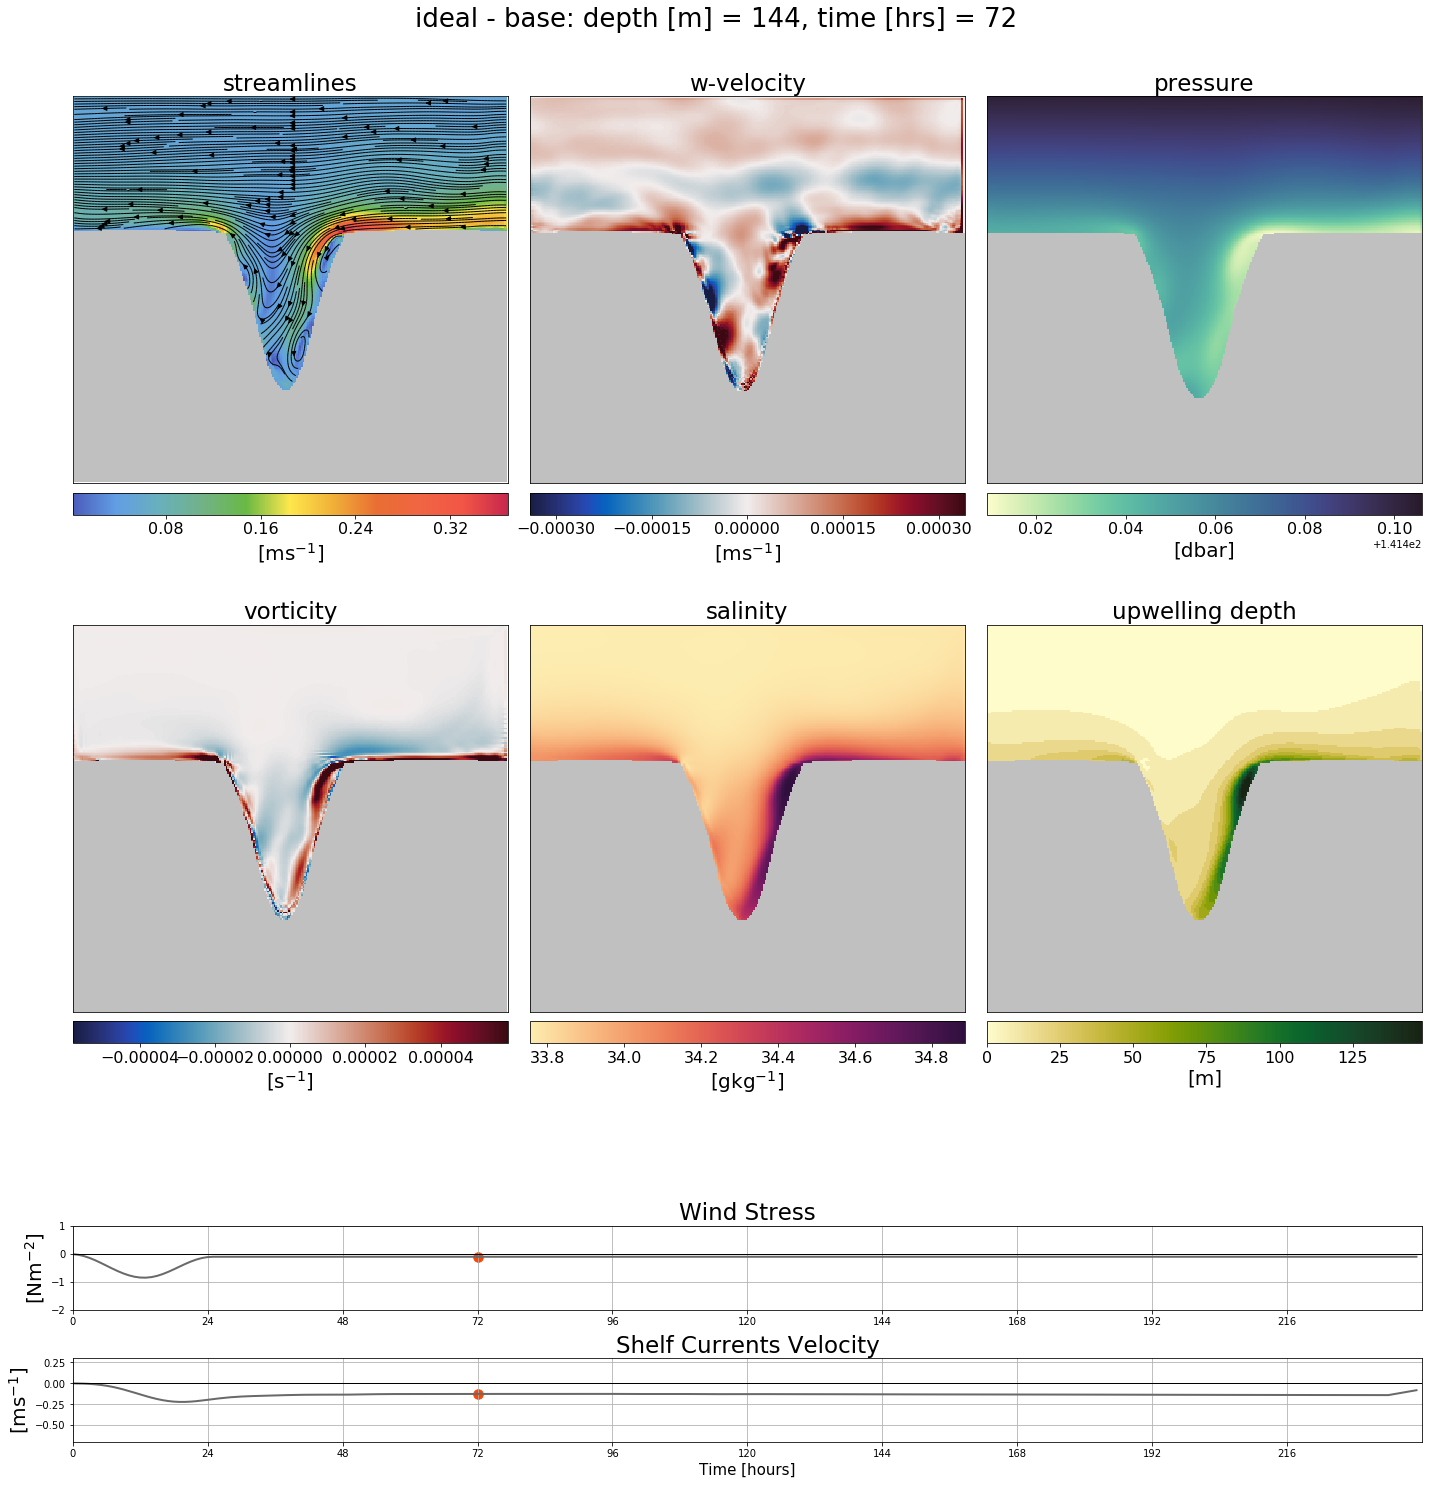

In [27]:
for time_ind in time_inds:
    print('time ', time_ind)
    for dep_ind_slice in dep_ind_slices:
        print('dep ', dep_ind_slice)

        start_time = datetime.now()
        x_slice, y_slice, u_nstg, v_nstg, speeds, vovecrtz, pressure_db, zeta, vosaline, depth_upwelled, sozotaux, avgU_abs_sm, tmask, deptht = execute_functions(dirname, fname, meshmaskname, dep_ind_slice, time_ind, vosaline_ref_profile)
        time_elapsed = datetime.now() - start_time
        print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

        # ------------------------------------------------------------

        fig = plot_story(x_slice, y_slice, u_nstg, v_nstg, speeds, 
                         vovecrtz, pressure_db, zeta, vosaline, depth_upwelled, sozotaux, avgU_abs_sm, tmask, deptht, 
                         dep_ind_slice, kind, case)
        fig.savefig('../writing_images/story_uvwpzsd_'+kind+'_'+case+'_'+str(dep_ind_slice)+'_'+str(time_ind)+'.png', dpi=100, bbox_inches='tight')
        plt.close(fig)